# Figure - CoMIGHT vs varying estimators on single views

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import math
import string
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.ticker import NullFormatter, ScalarFormatter, StrMethodFormatter
from sklearn.metrics import roc_auc_score

seed = 12345
rng = np.random.default_rng(seed)

In [4]:
root_dir = Path("/Volumes/Extreme Pro/cancer/output/final_resultsv2/")

sim_names = ["mean_shiftv4", "multi_modalv2", "multi_equal"]

n_dims_1 = 512 - 6
n_samples = 1024
n_repeats = 100

# Plot Figure S7 (varying n_samples full other views)

In [572]:
FIG_PATH = Path("/Volumes/Extreme Pro/cancer/output/figures/")
FIG_PATH.mkdir(parents=True, exist_ok=True)

In [573]:
sim_names = ["mean_shiftv4", "multi_modalv2", "multi_equal"]

In [574]:
model_names = [
    "comight",
    "knn",
]

In [575]:
# varying n_samples
df = pd.DataFrame()

metric = "sas98"
for model in model_names:
    for sim_name in sim_names:
        fname = (
            root_dir
            / f"results_vs_nsamples_{sim_name}_{model}_{metric}_{n_dims_1}_{n_repeats}.csv"
        )
        result_df = pd.read_csv(fname, index_col=None)

        # display(result_df.head())

        df = pd.concat((df, result_df), axis=0)

In [576]:
model_names = [
    "knn_viewone",
    "might_viewone",
]

viewone_df = pd.DataFrame()
metric = "sas98"
for model in model_names:
    for sim_name in sim_names:
        fname = (
            root_dir
            / f"results_vs_nsamples_{sim_name}_{model}_{metric}_{n_dims_1}_{n_repeats}.csv"
        )
        result_df = pd.read_csv(fname, index_col=None)

        # display(result_df.head())

        viewone_df = pd.concat((viewone_df, result_df), axis=0)

In [577]:
model_names = [
    "knn_viewtwo",
    "might_viewtwo",
]

viewtwo_df = pd.DataFrame()
metric = "sas98"
for model in model_names:
    for sim_name in sim_names:
        fname = (
            root_dir
            / f"results_vs_nsamples_{sim_name}_{model}_{metric}_{n_dims_1}_{n_repeats}.csv"
        )
        result_df = pd.read_csv(fname, index_col=None)

        # display(result_df.head())

        viewtwo_df = pd.concat((viewtwo_df, result_df), axis=0)

In [578]:
print(df.shape)
display(df.head())

(1800, 5)


,n_samples,sim_type,model,metric,metric_value
0,256,mean_shiftv4,comight,sas98,0.007812
1,256,mean_shiftv4,comight,sas98,0.015625
2,256,mean_shiftv4,comight,sas98,0.007812
3,256,mean_shiftv4,comight,sas98,0.046875
4,256,mean_shiftv4,comight,sas98,0.007812


In [579]:
df = pd.concat((df, viewone_df, viewtwo_df), axis=0)

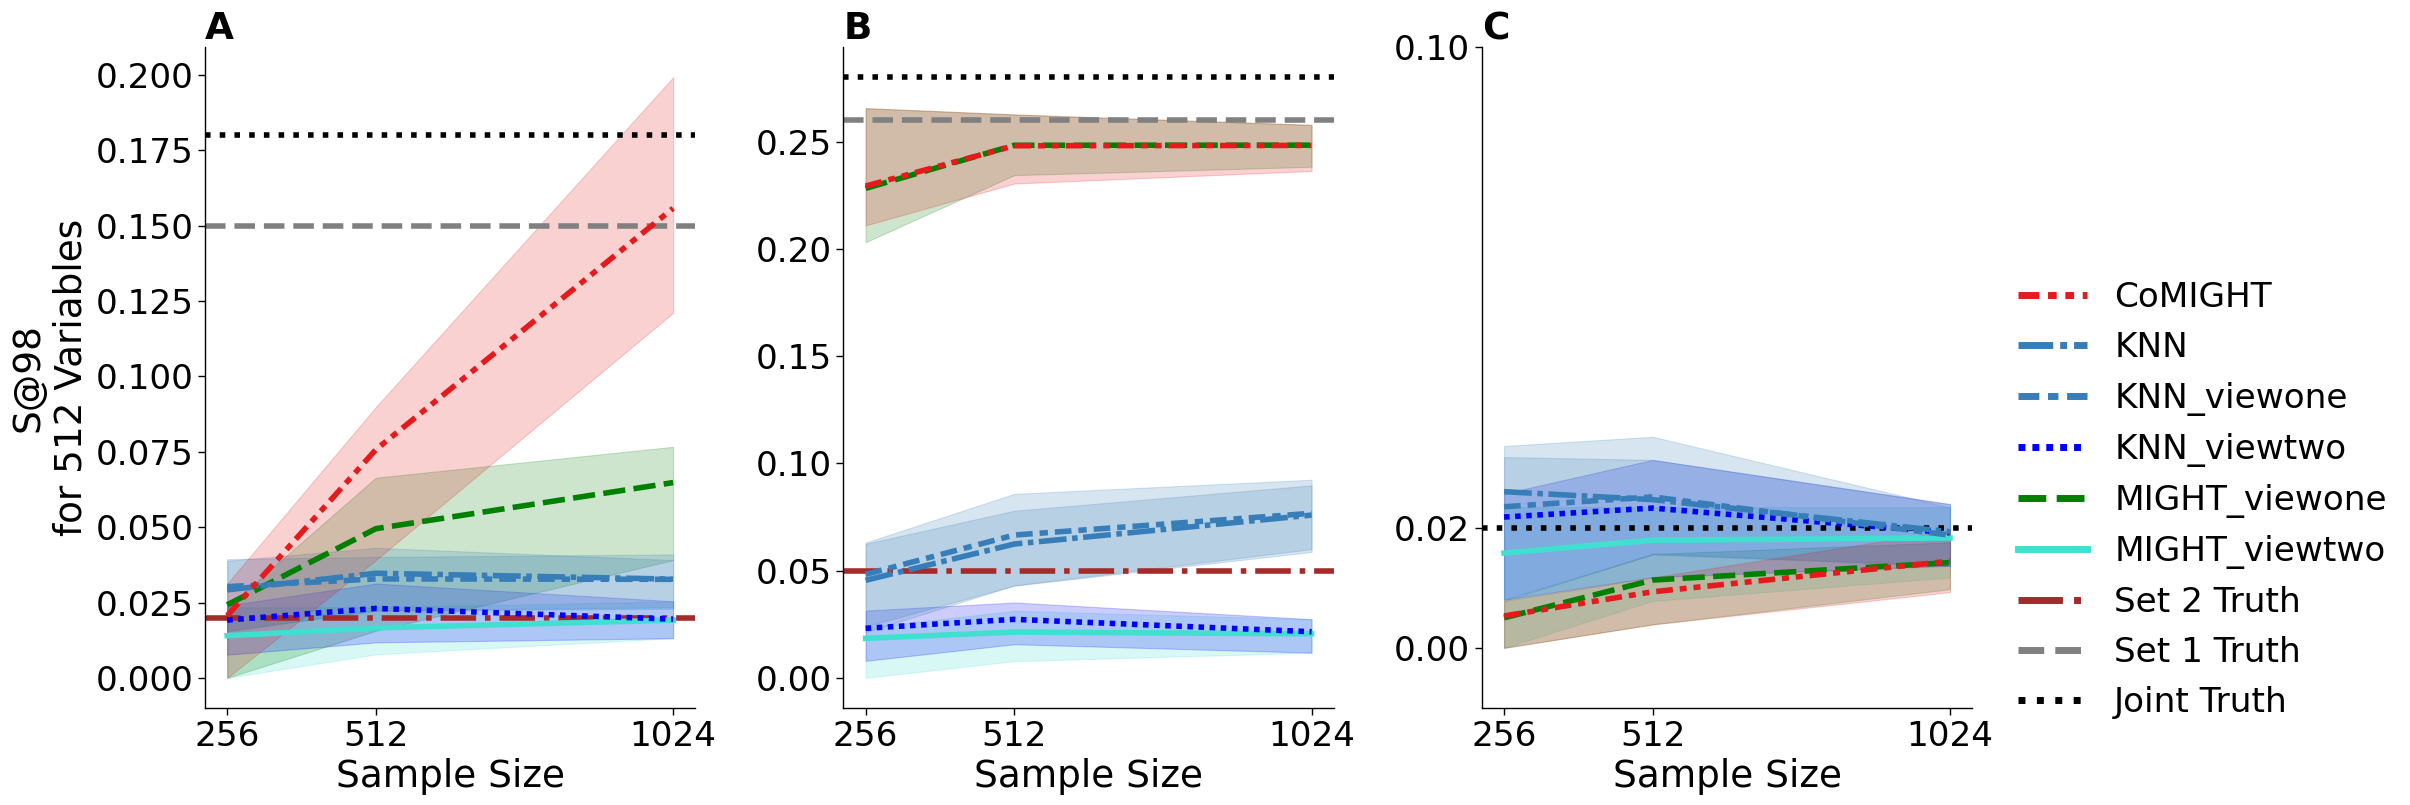

In [582]:
sns.set_context("paper", font_scale=2.8)

# in order of rows
truths = [
    {
        "mean_shiftv4": 0.18,
        "mean_shiftv3": 0.31,
        "multi_modalv2": 0.28,
        "multi_equal": 0.02,
    },
    {
        "mean_shiftv4": 0.15,
        "multi_modalv2": 0.26,
        "multi_equal": 0.02,
    },
    {
        "mean_shiftv4": 0.02,
        "multi_modalv2": 0.05,
        "multi_equal": 0.02,
    },
]
truth_labels = [
    "Joint Truth",
    "Set 1 Truth",
    "Set 2 Truth",
]
truth_colors = [
    "black",
    "gray",
    "brown",
]
truth_ls = [
    ":",
    "--",
    "dashdot",
]

titles = ["Linear", "Nonlinear", "Independent"]

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
for iview in range(len(truths)):
    for irow, sim_name in enumerate(sim_names):
        if sim_name == "multi_equal" and iview > 0:
            continue
        axs[irow].axhline(
            [truths[iview][sim_name]],
            ls=truth_ls[iview],
            label=truth_labels[iview],
            color=truth_colors[iview],
            linewidth=4,
        )

for idx, sim_name in enumerate(sim_names):
    plot_df = df[df["sim_type"] == sim_name]

    plot_df["model"] = plot_df["model"].apply(lambda x: str(x).lower())
    plot_df["model"] = plot_df["model"].str.replace(
        "comight-cmi", "CoMIGHT", regex=False
    )
    plot_df["model"] = plot_df["model"].str.replace("comight", "CoMIGHT", regex=False)
    plot_df["model"] = plot_df["model"].str.replace("might", "MIGHT", regex=False)
    plot_df["model"] = plot_df["model"].str.replace("knn", "KNN", regex=False)
    plot_df["model"] = plot_df["model"].str.replace("ksg", "KSG", regex=False)

    palette = {
        "CoMIGHT": "#e41a1c",
        "KNN": "#377eb8",
        "KNN_viewone": "#377eb8",
        "KNN_viewtwo": "blue",
        "MIGHT_viewone": "green",
        "MIGHT_viewtwo": "turquoise",
    }
    linestyles = {
        "KNN_viewone": "--",
        "KNN_viewtwo": ":",
        "MIGHT_viewone": "--",
        "MIGHT_viewtow": ":",
    }

    # begin plotting
    ax = axs[idx]

    hue_order = sorted([model for model in plot_df["model"].unique()])[::-1]
    ax = sns.lineplot(
        data=plot_df,
        x="n_samples",
        y="metric_value",
        hue="model",
        hue_order=hue_order,
        style="model",
        style_order=hue_order,
        ax=ax,
        palette=palette,
        linewidth=4,
        errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
    )

    ax.set_xticks([256, 512, 1024])

    # set y lim and ticks
    # ax.set_ylim([-0.001, truths[irow][sim_name] + 0.4 * truths[irow][sim_name]])
    if sim_name == "multi_equal":
        ax.set_yticks([0, 0.1, truths[irow][sim_name]])
    # else:
    #     ax.set_yticks([0, truths[irow][sim_name]])

    if sim_name == "multi_equal":
        ax.set(ylim=[-0.01, 0.1])

    sns.despine(right=True, ax=ax)
    ax.get_legend().set_visible(False)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    if irow == 0:
        ax.set_title(titles[idx])

    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_title(
        string.ascii_uppercase[idx],
        loc="left",
        weight="bold",
    )

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for icol in range(len(sim_names)):
    axs[icol].set_xlabel("Sample Size")

axs[0].set_ylabel("Conditional Mutual Information\nfor 512 Variables")
axs[0].set_ylabel("S@98\nfor 512 Variables")
fig.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)
legend_locs = [(1.08, 0.99), (1.1, 0.69)]
for i in range(2):
    leg = axs[0].legend(
        bbox_to_anchor=legend_locs[i],
        bbox_transform=plt.gcf().transFigure,
        ncol=1,
        loc="upper center",
        reverse=True,
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

fig_name = "figure-s7"
plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches="tight")
plt.show()